In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분석

## Load Data

In [8]:
air_visit_data = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip')
air_store_info = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip')
hpg_store_info = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip')
air_reserve = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip')
hpg_reserve = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip')
store_id_relation = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip')
sample_submission = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip')
date_info = pd.read_csv('./input/recruit-restaurant-visitor-forecasting/date_info.csv.zip')

## EDA

In [9]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [10]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [11]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [12]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [13]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [14]:
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [15]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


## 시각화

In [16]:
# date time 분리 (date, time, year, month, day)
def split_date_time(df):
    result = df.copy()
    if 'visit_datetime' in result.columns:
        result.loc[:,'visit_datetime'] = pd.to_datetime(result['visit_datetime'])
        result.loc[:,'visit_date']  = [str(d.date()) for d in result['visit_datetime']]       
        result.loc[:,'visit_time']  = [str(d.time()) for d in result['visit_datetime']]             
    if 'reserve_datetime' in df.columns:
        result.loc[:,'reserve_datetime'] = pd.to_datetime(result['reserve_datetime'])
        result.loc[:,'reserve_date']  = [str(d.date()) for d in result['reserve_datetime']]       
        result.loc[:,'reserve_time']  = [str(d.time()) for d in result['reserve_datetime']]        
        
    if 'visit_date' in result.columns:        
        result = pd.merge(result, date_info, how='inner', left_on='visit_date', right_on='calendar_date')
        result.loc[:,'visit_date'] = pd.to_datetime(result['visit_date'])
        result['visit_year'] = result.visit_date.dt.year
        result['visit_month']  = result.visit_date.dt.month
        result['visit_day'] = result.visit_date.dt.day

    if 'reserve_date' in result.columns:        
        result = pd.merge(result, date_info ,how='inner', left_on='reserve_date', right_on='calendar_date')
        result.loc[:,'reserve_date'] = pd.to_datetime(result['reserve_date'])
        result['reserve_year'] = result.reserve_date.dt.year
        result['reserve_month']  = result.reserve_date.dt.month
        result['reserve_day'] = result.reserve_date.dt.day
    return result

### 전체 방문자 추이 확인

In [17]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df.head()

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-13,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-13,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-13,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-13,18,2016-01-13,Wednesday,0,2016,1,13


#### 전체 기간

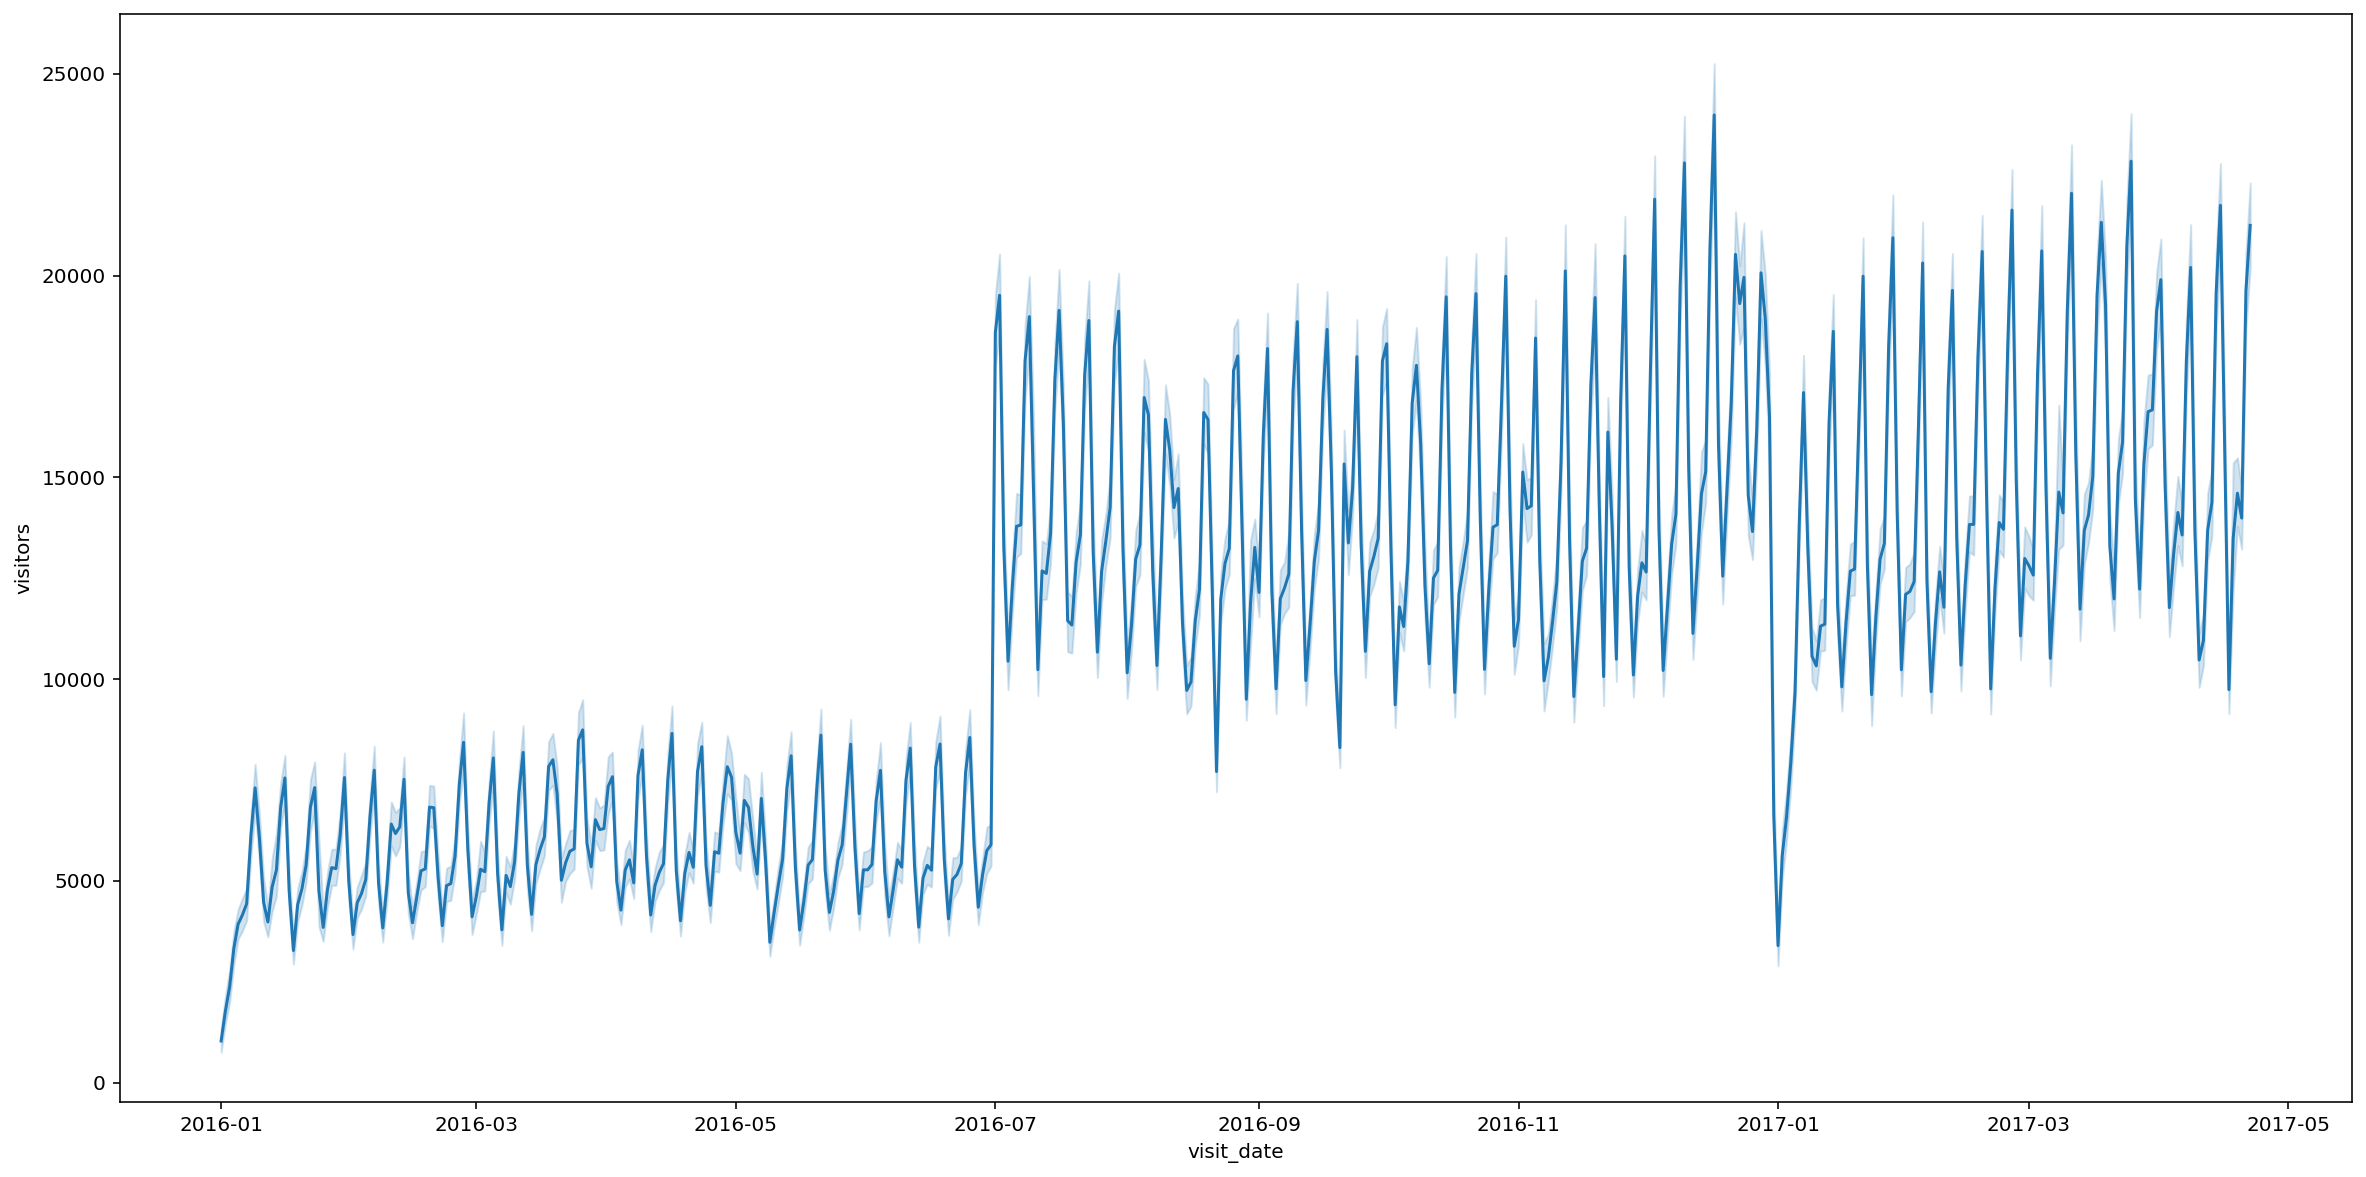

In [18]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
plt.show()

#### 요일별

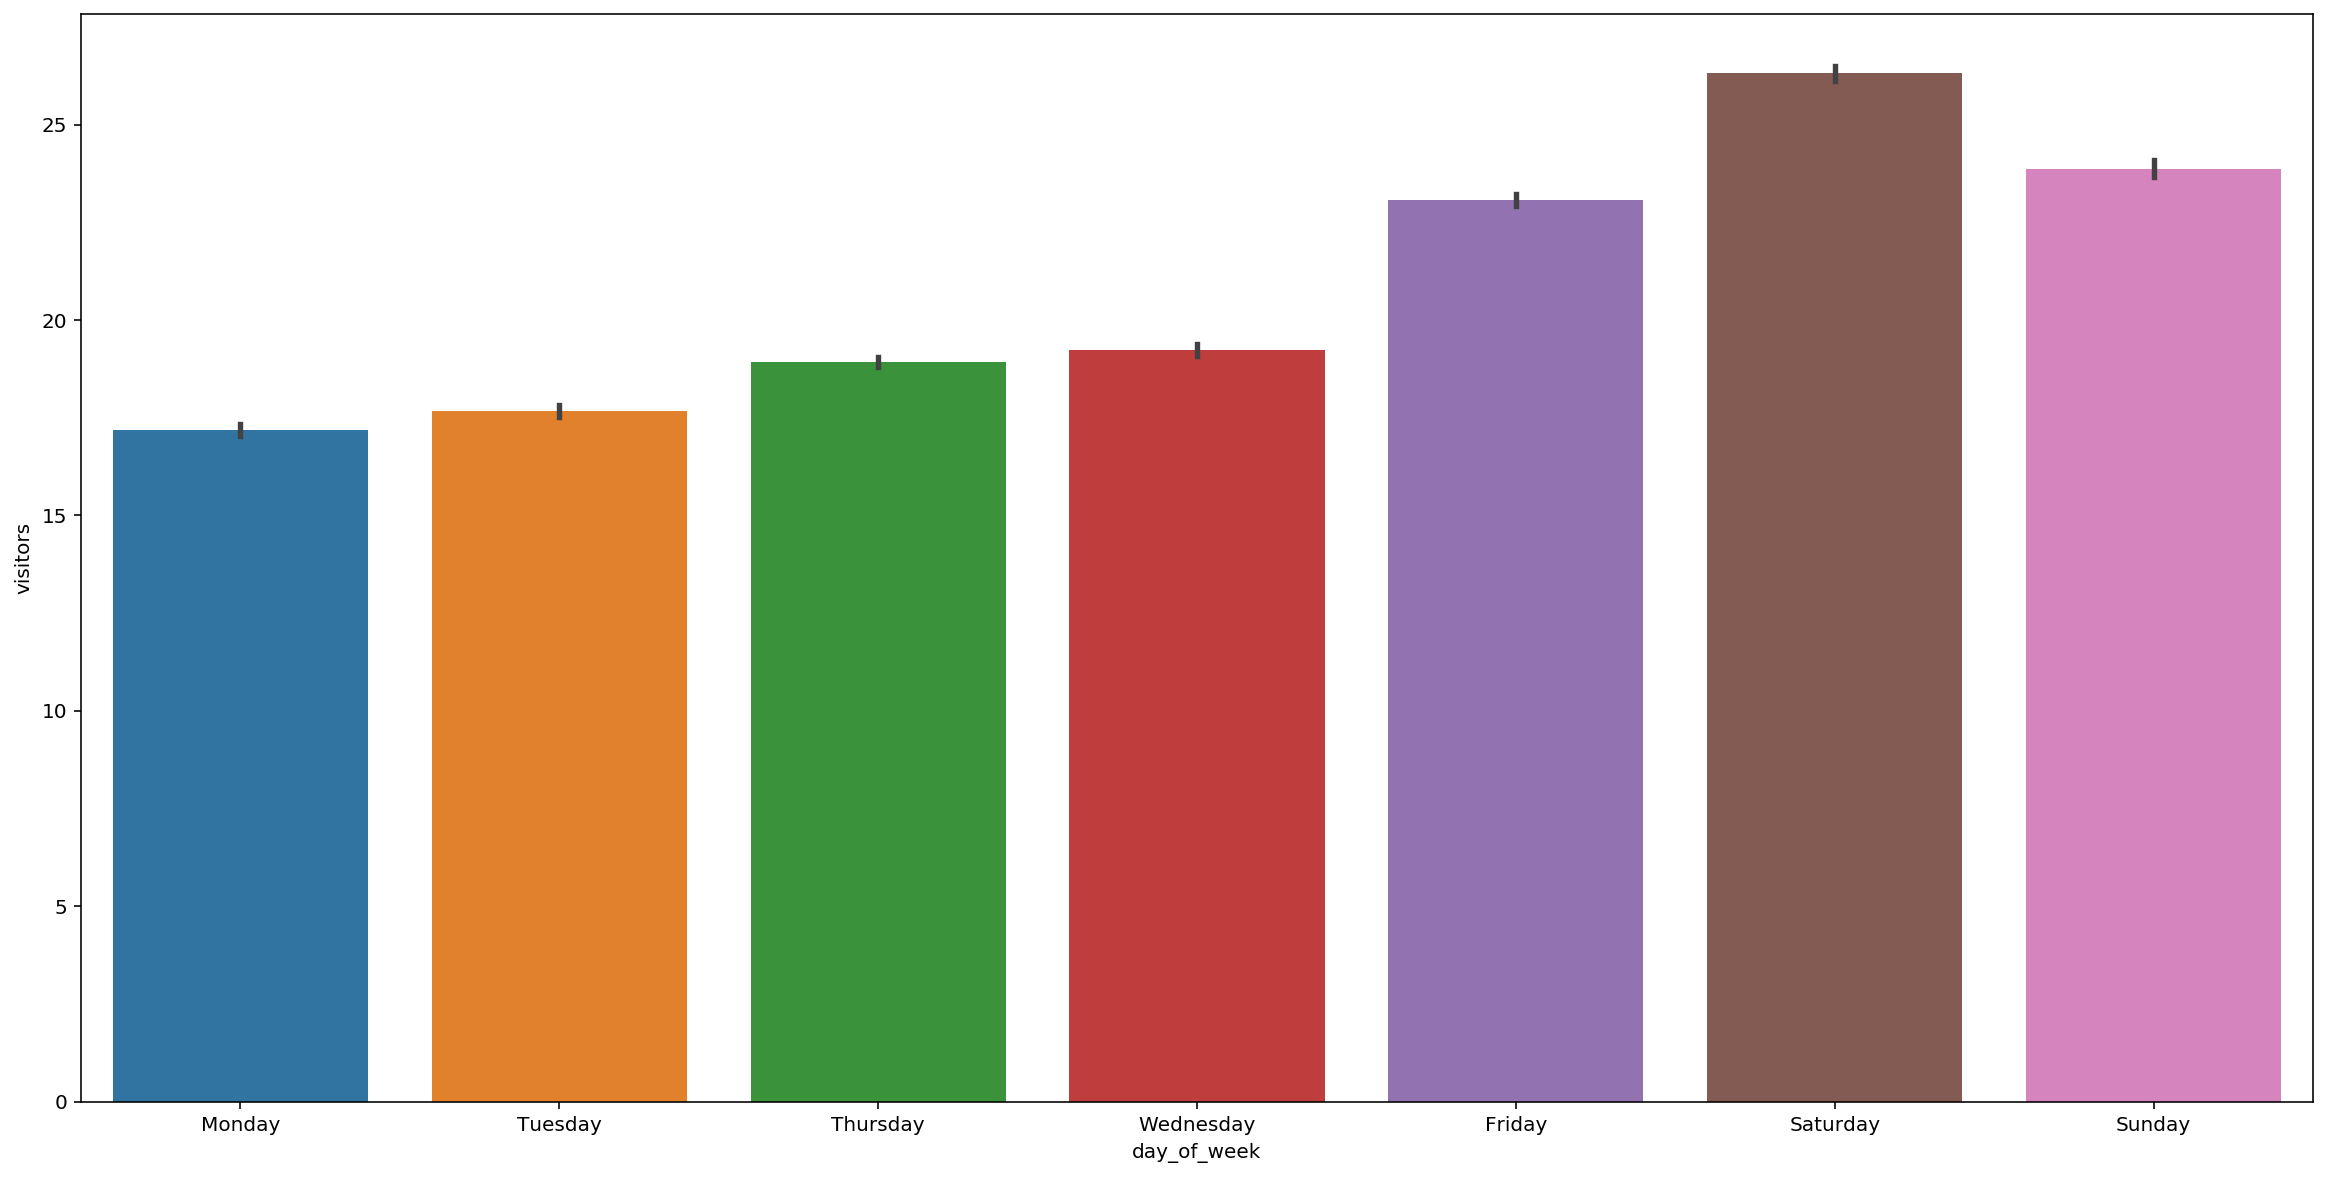

In [19]:
m = ['Monday', 'Tuesday', 'Thursday', 'Wednesday','Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='day_of_week', y='visitors', order=m)
plt.show()

#### 월별

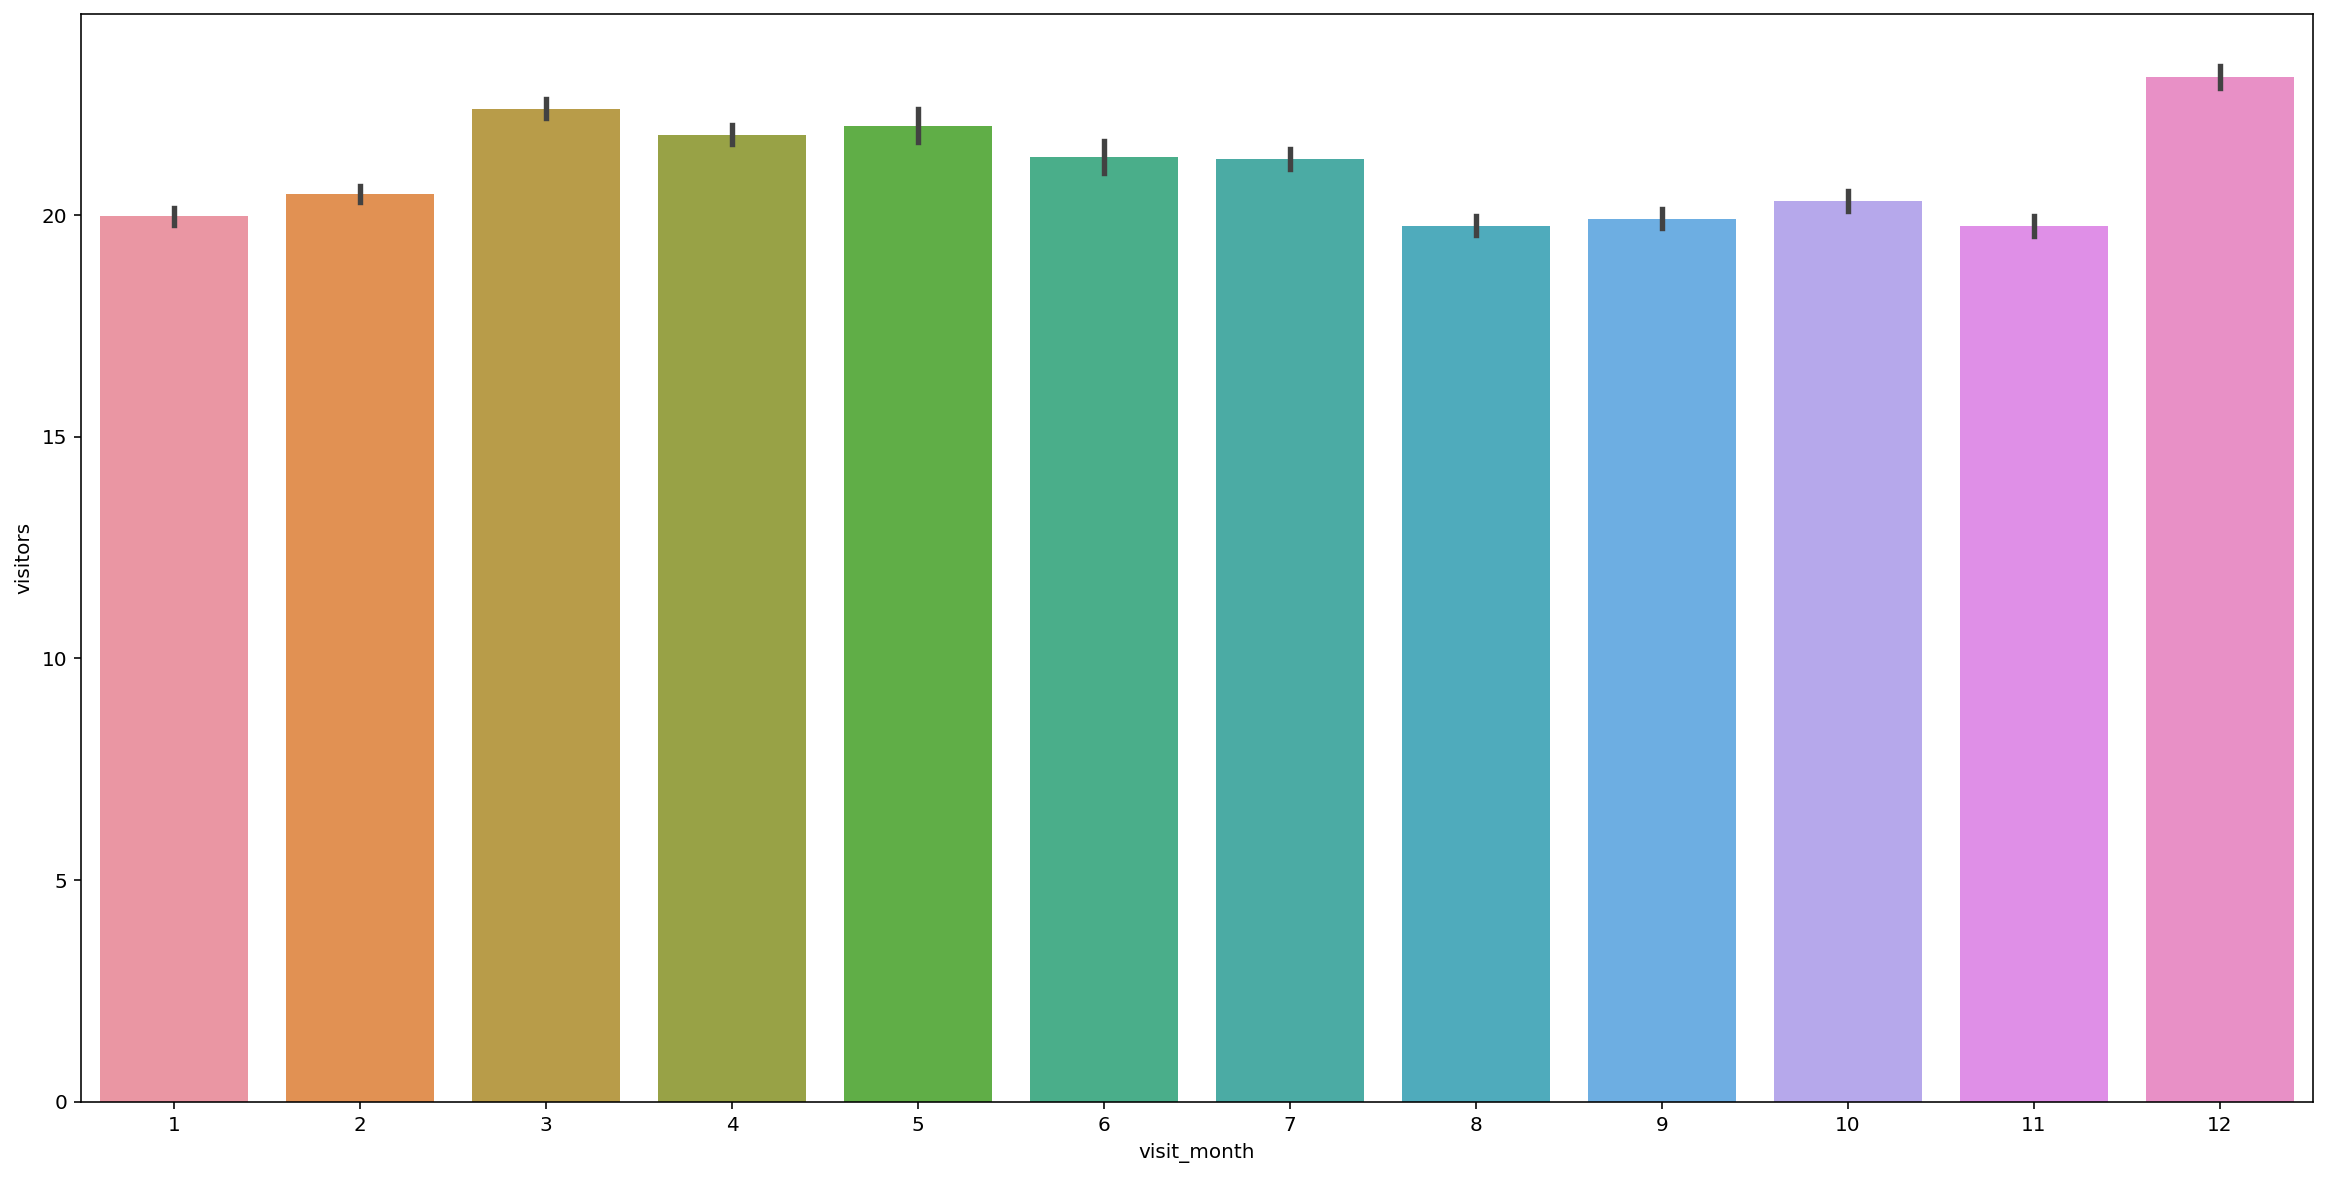

In [20]:
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='visit_month', y='visitors')
plt.show()

#### 전체 기간동안 방문자와 예약자 추이

In [21]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92373,air_683371d9baabf410,2017-05-23 12:00:00,2017-04-22 11:00:00,5,2017-05-23,12:00:00,2017-04-22,11:00:00,2017-05-23,Tuesday,0,2017,5,23,2017-04-22,Saturday,0,2017,4,22
92374,air_df554c4527a1cfe6,2017-05-27 19:00:00,2017-04-22 20:00:00,6,2017-05-27,19:00:00,2017-04-22,20:00:00,2017-05-27,Saturday,0,2017,5,27,2017-04-22,Saturday,0,2017,4,22
92375,air_683371d9baabf410,2017-05-28 11:00:00,2017-04-22 11:00:00,6,2017-05-28,11:00:00,2017-04-22,11:00:00,2017-05-28,Sunday,0,2017,5,28,2017-04-22,Saturday,0,2017,4,22
92376,air_f911308e19d64236,2017-05-28 12:00:00,2017-04-22 15:00:00,6,2017-05-28,12:00:00,2017-04-22,15:00:00,2017-05-28,Sunday,0,2017,5,28,2017-04-22,Saturday,0,2017,4,22


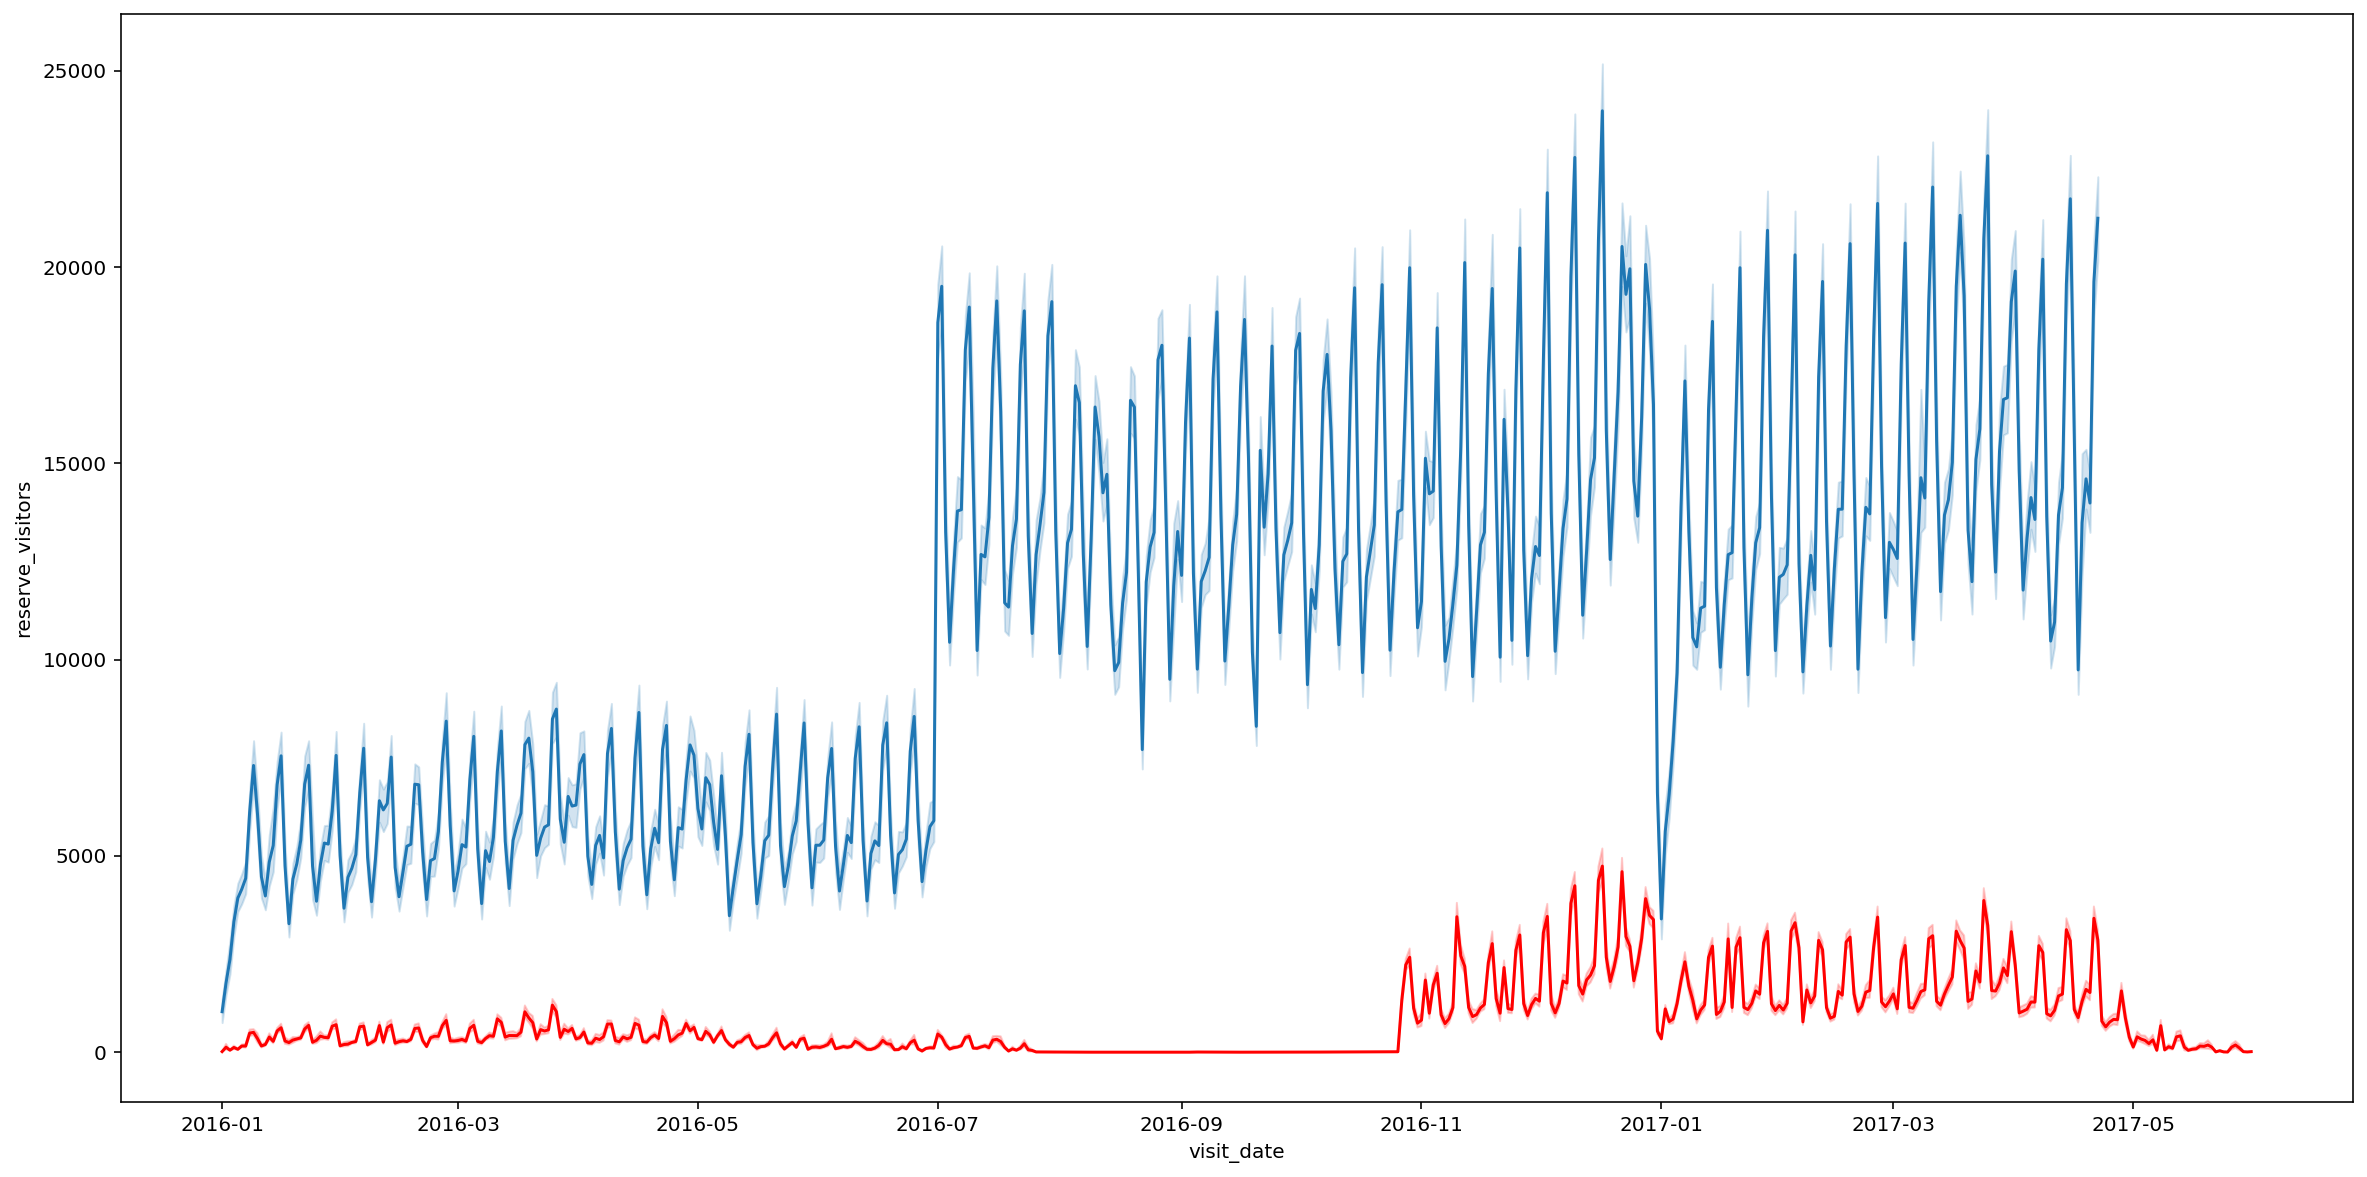

In [22]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
sns.lineplot(data = air_reserve_df, x='visit_date', y='reserve_visitors', color='r', estimator=sum)
plt.show()

### 2016년도 추이 확인

### 예약자 수

#### air

In [23]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


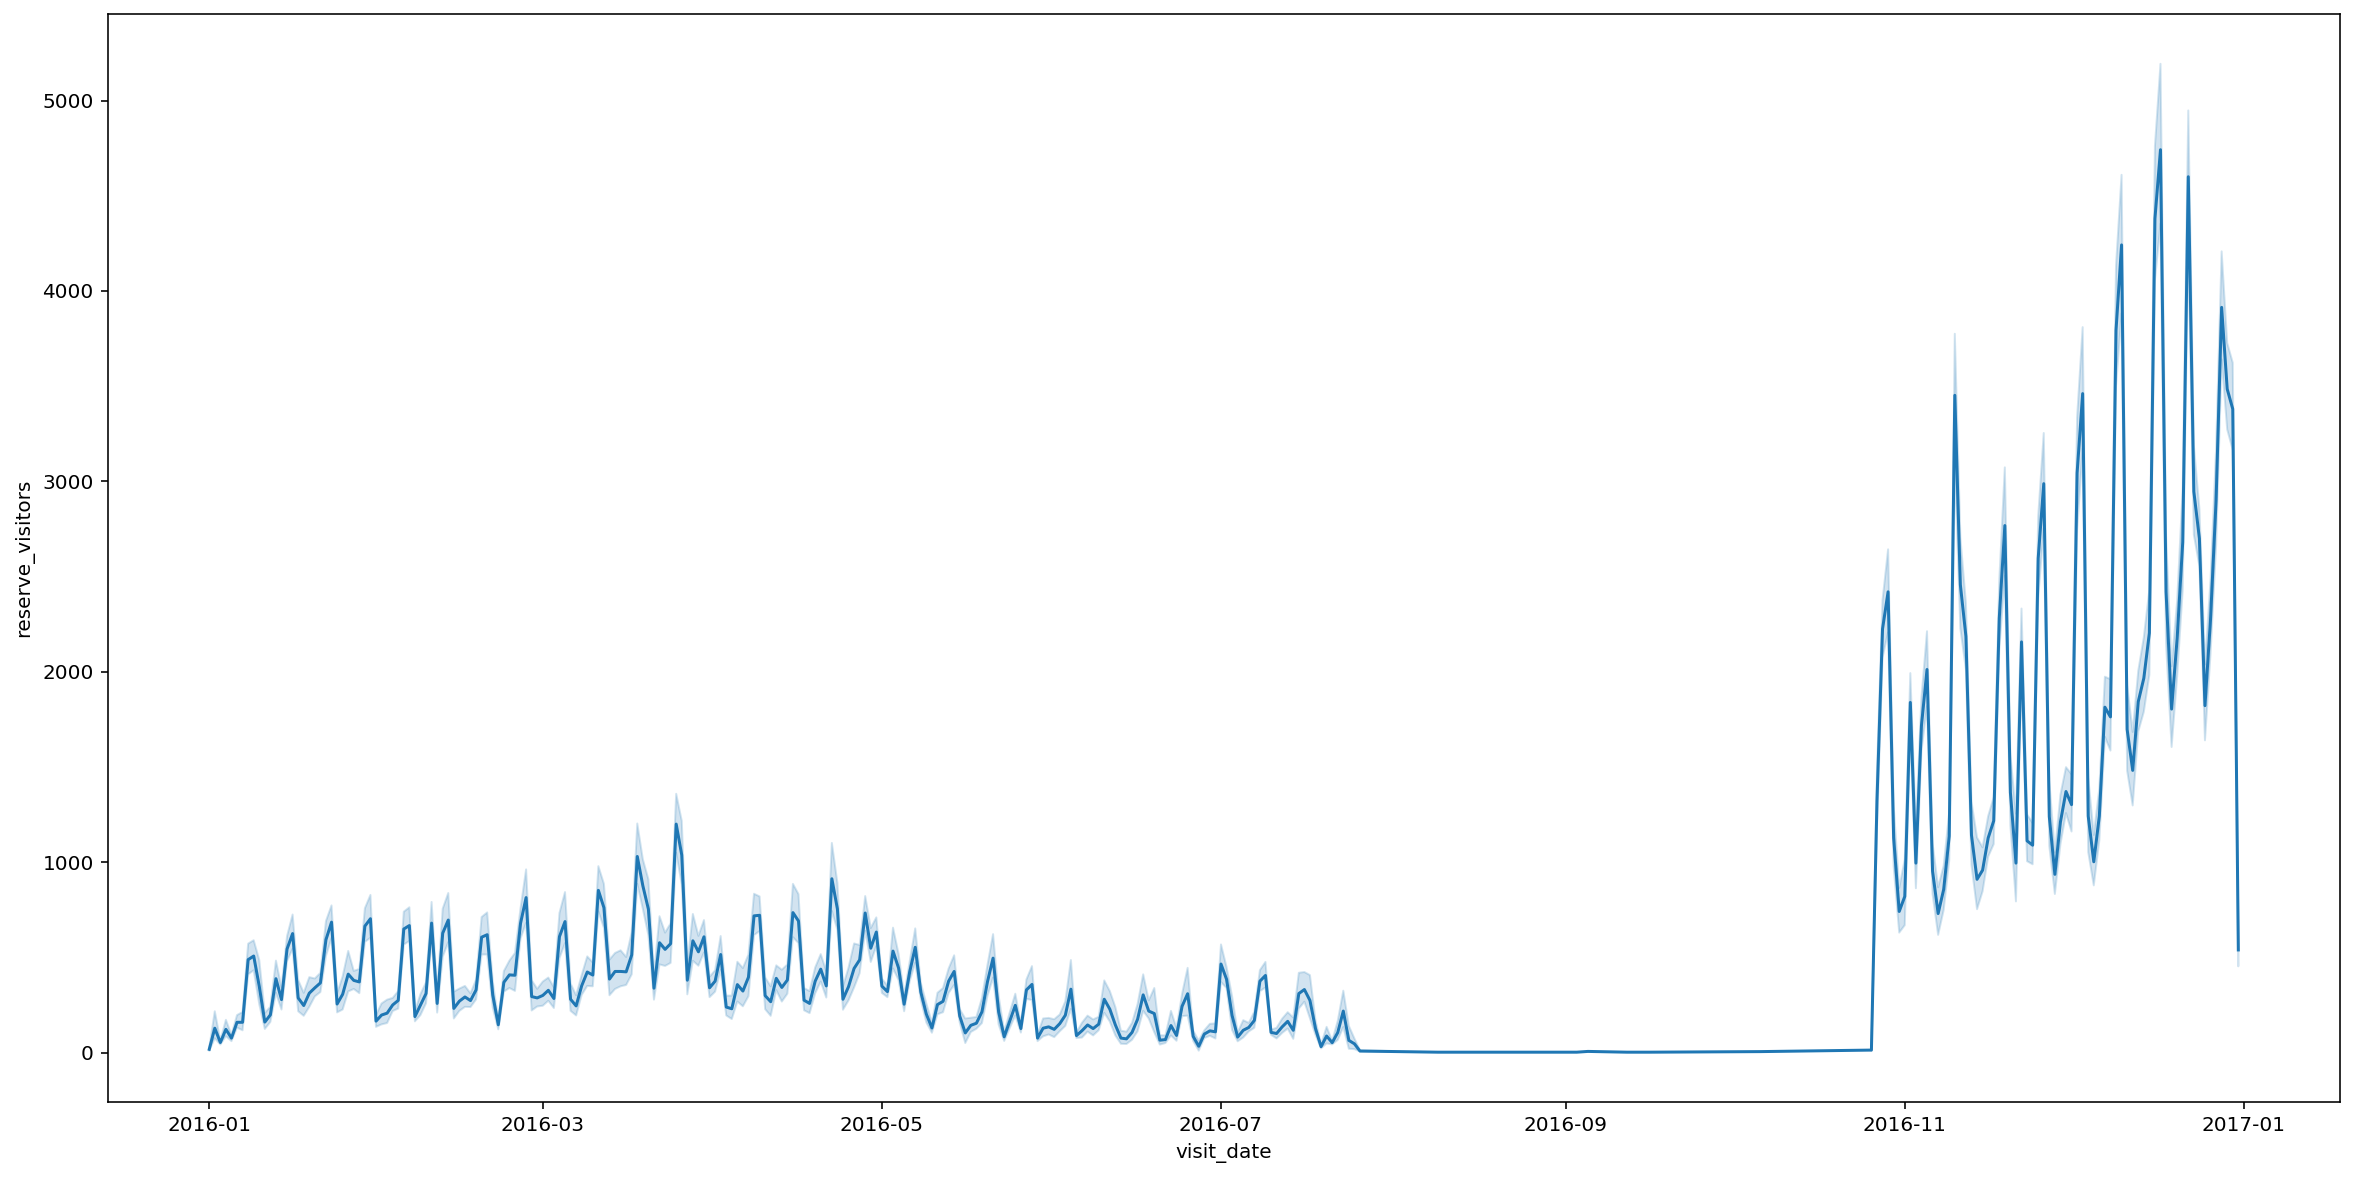

In [24]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_reserve_df[air_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

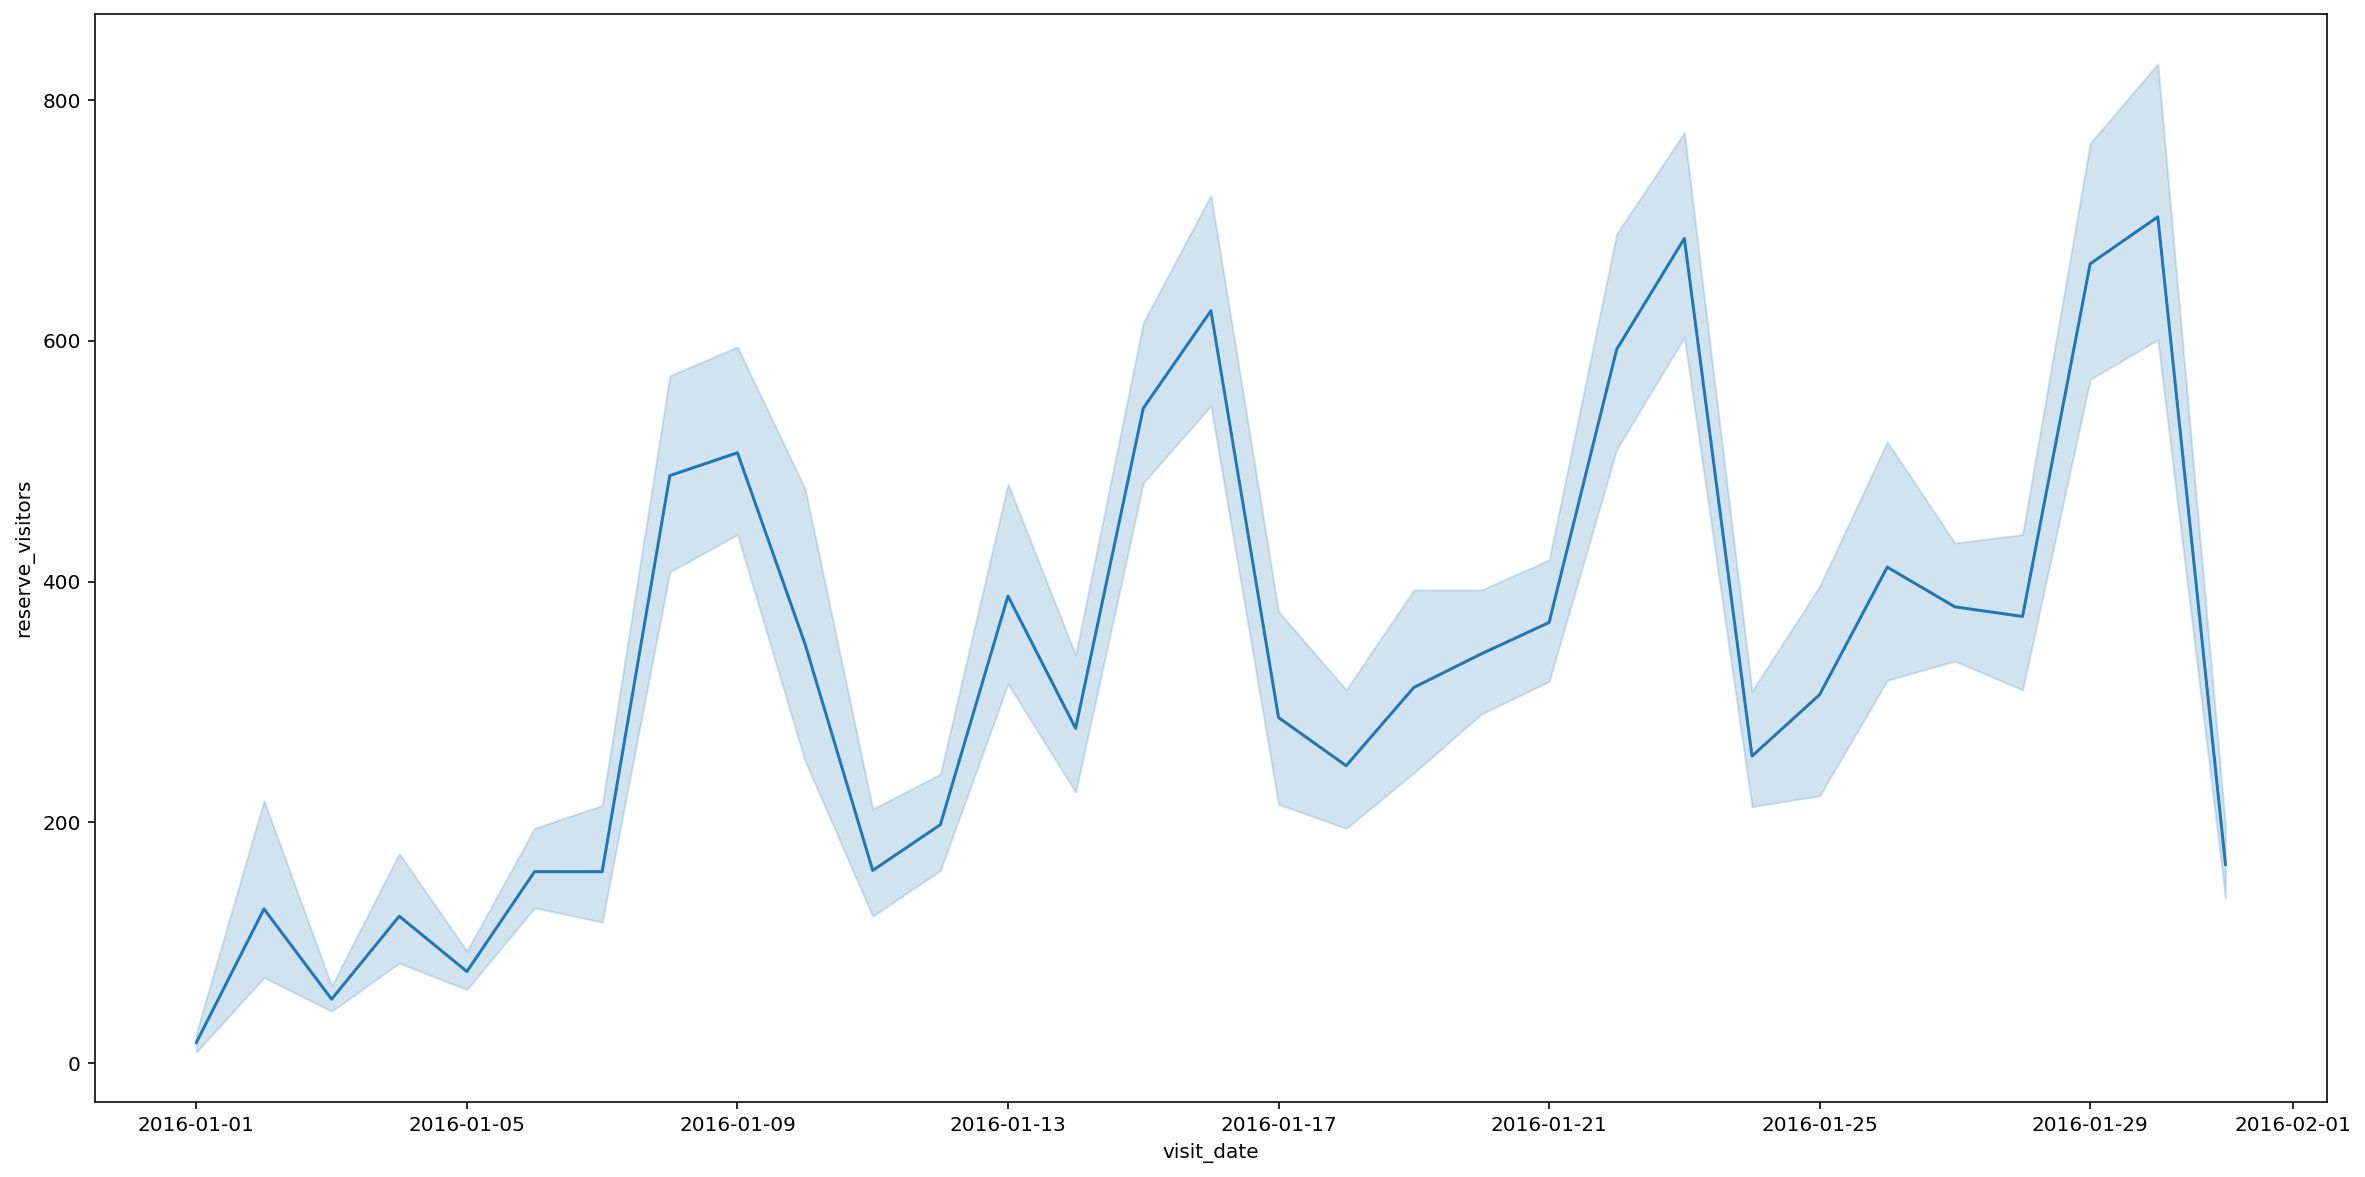

In [25]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_reserve_df.loc[(air_reserve_df['visit_year'] == 2016) & (air_reserve_df['visit_month'] == 1)], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

#### hpg

In [26]:
hpg_reserve_df = split_date_time(hpg_reserve)
hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00,2016-01-01,09:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16:00:00,2016-01-01,14:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,17:00:00,2016-01-01,11:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,17:00:00,2016-01-01,03:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


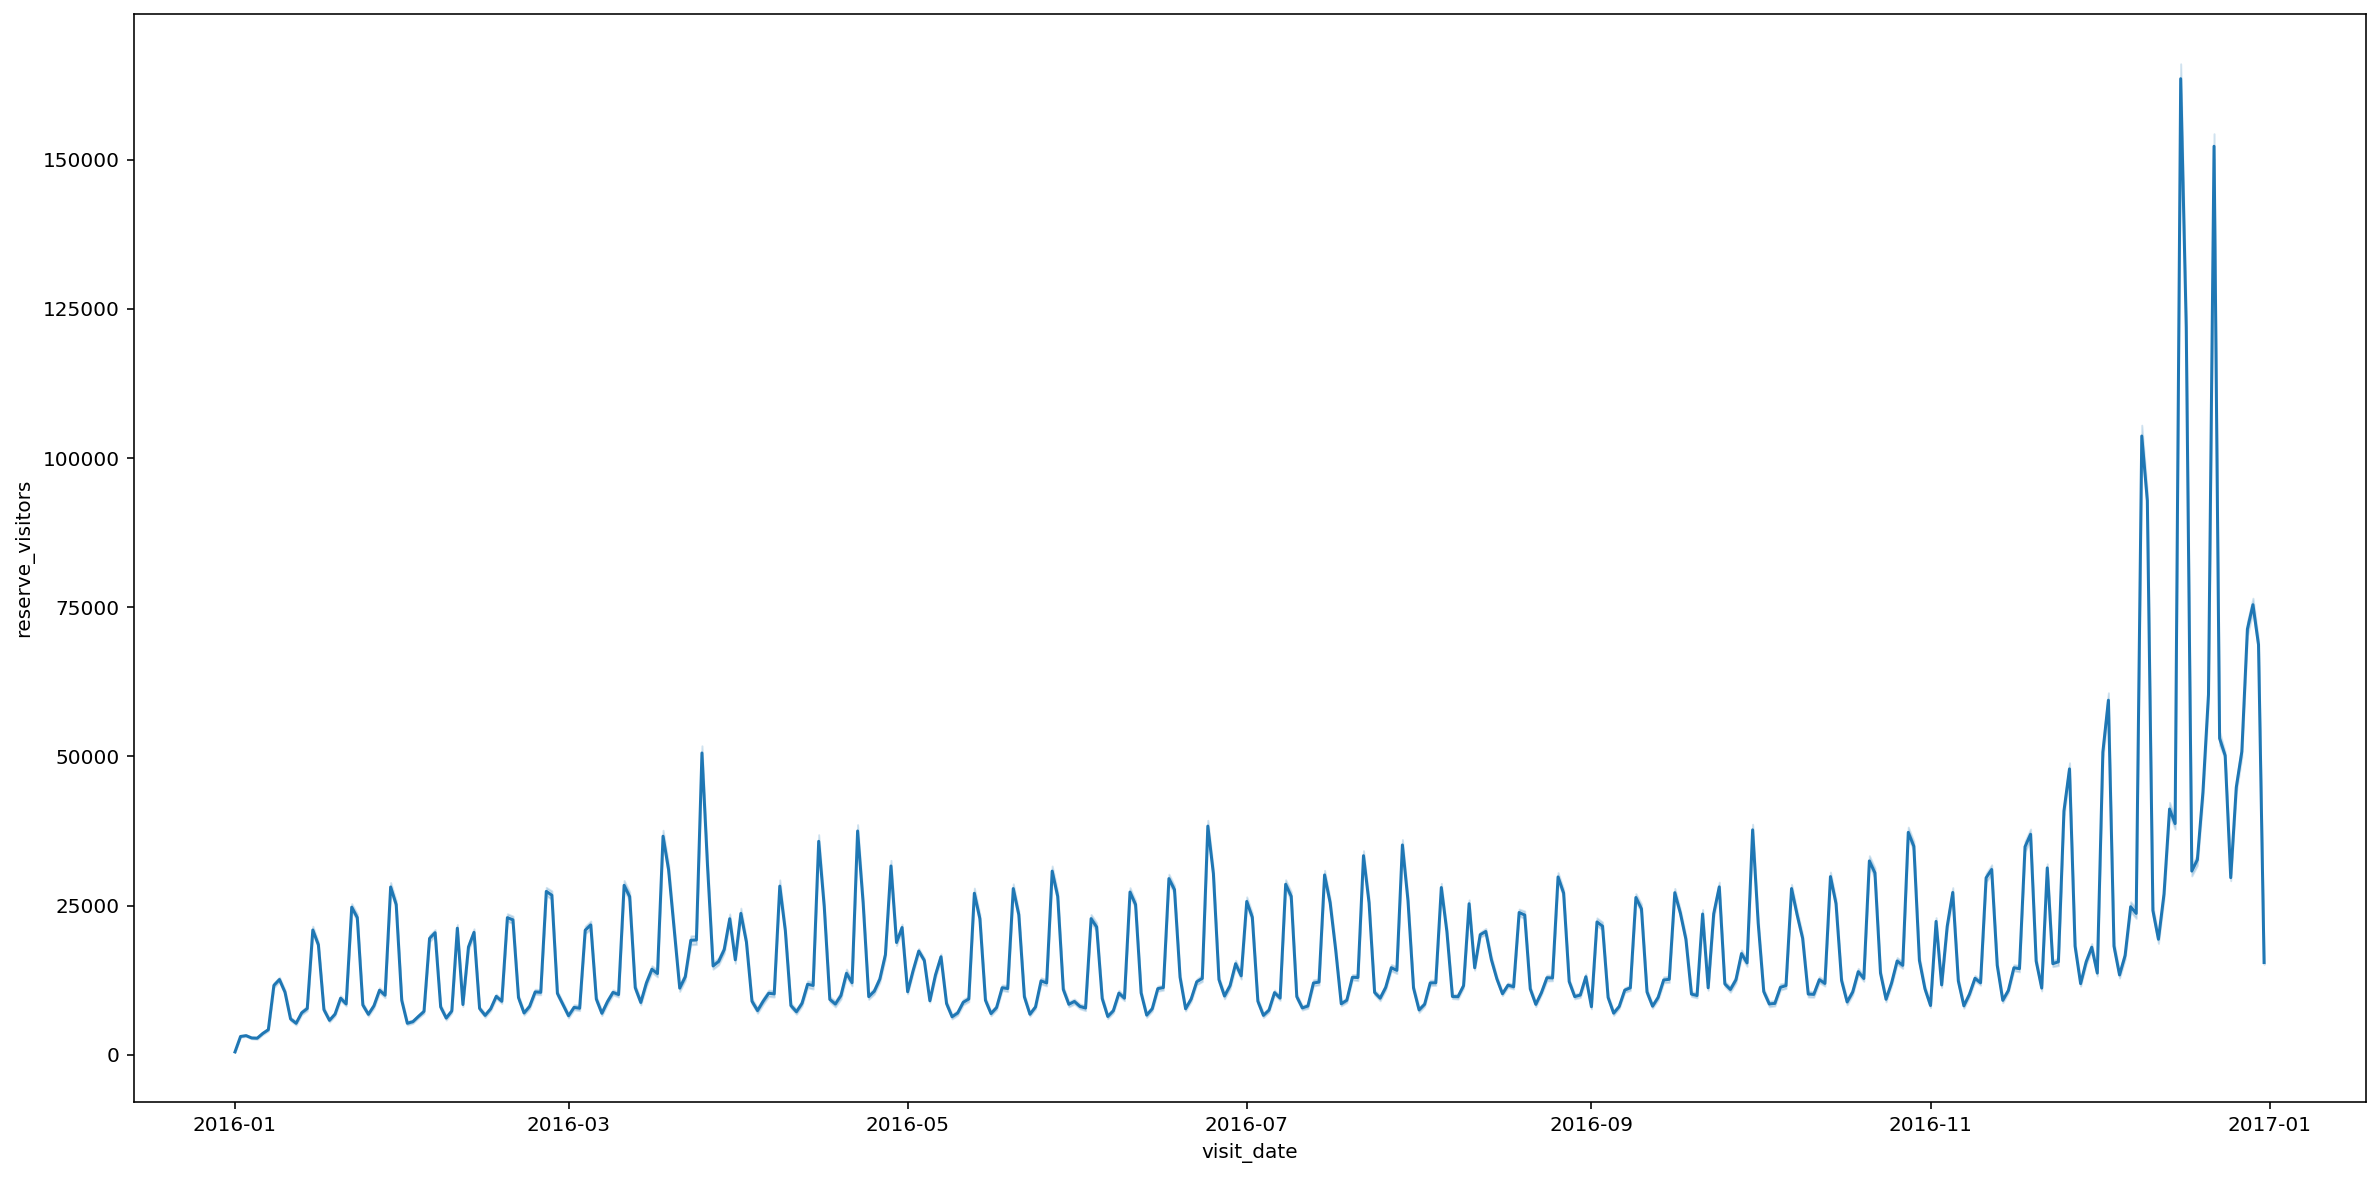

In [27]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_reserve_df[hpg_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

### 방문자 수

In [28]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
air_visit_df.head()

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-14,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-15,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-16,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-18,18,2016-01-13,Wednesday,0,2016,1,13


In [29]:
air_visit_df.loc[air_visit_df.visit_year==2016]

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-14,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-15,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-16,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-18,18,2016-01-13,Wednesday,0,2016,1,13
...,...,...,...,...,...,...,...,...,...
252103,air_dfad598ff642dab7,2017-04-18,25,2016-01-02,Saturday,1,2016,1,2
252104,air_db4b38ebe7a7ceff,2017-04-19,9,2016-01-02,Saturday,1,2016,1,2
252105,air_232dcee6f7c51d37,2017-04-20,9,2016-01-02,Saturday,1,2016,1,2
252106,air_3b6438b125086430,2017-04-21,8,2016-01-02,Saturday,1,2016,1,2


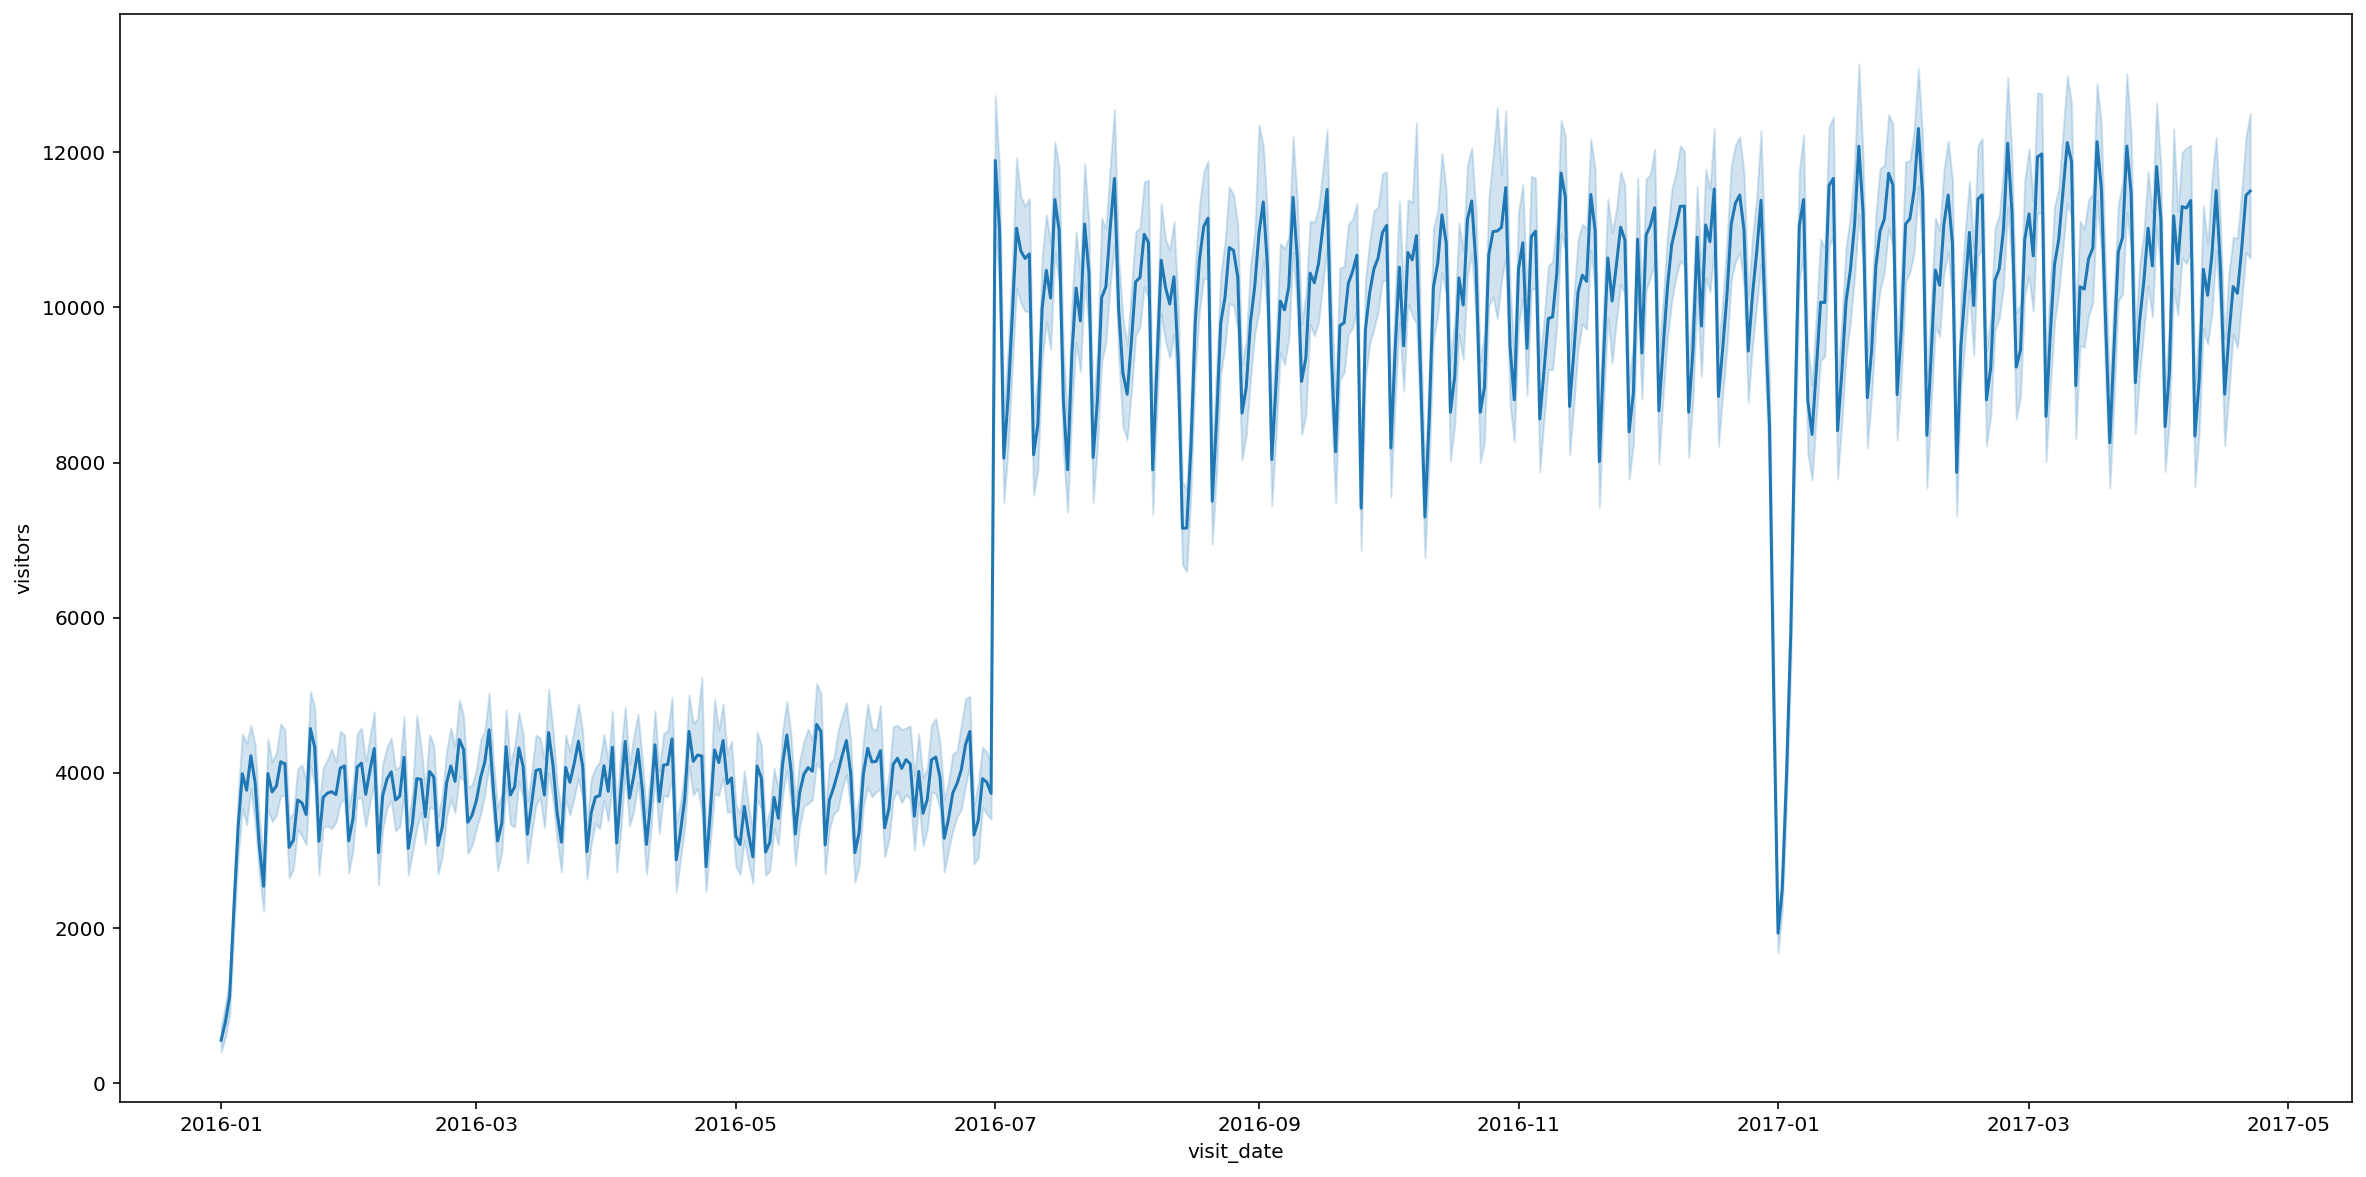

In [30]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df[air_visit_df.visit_year==2016], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 한달 기간 시각화

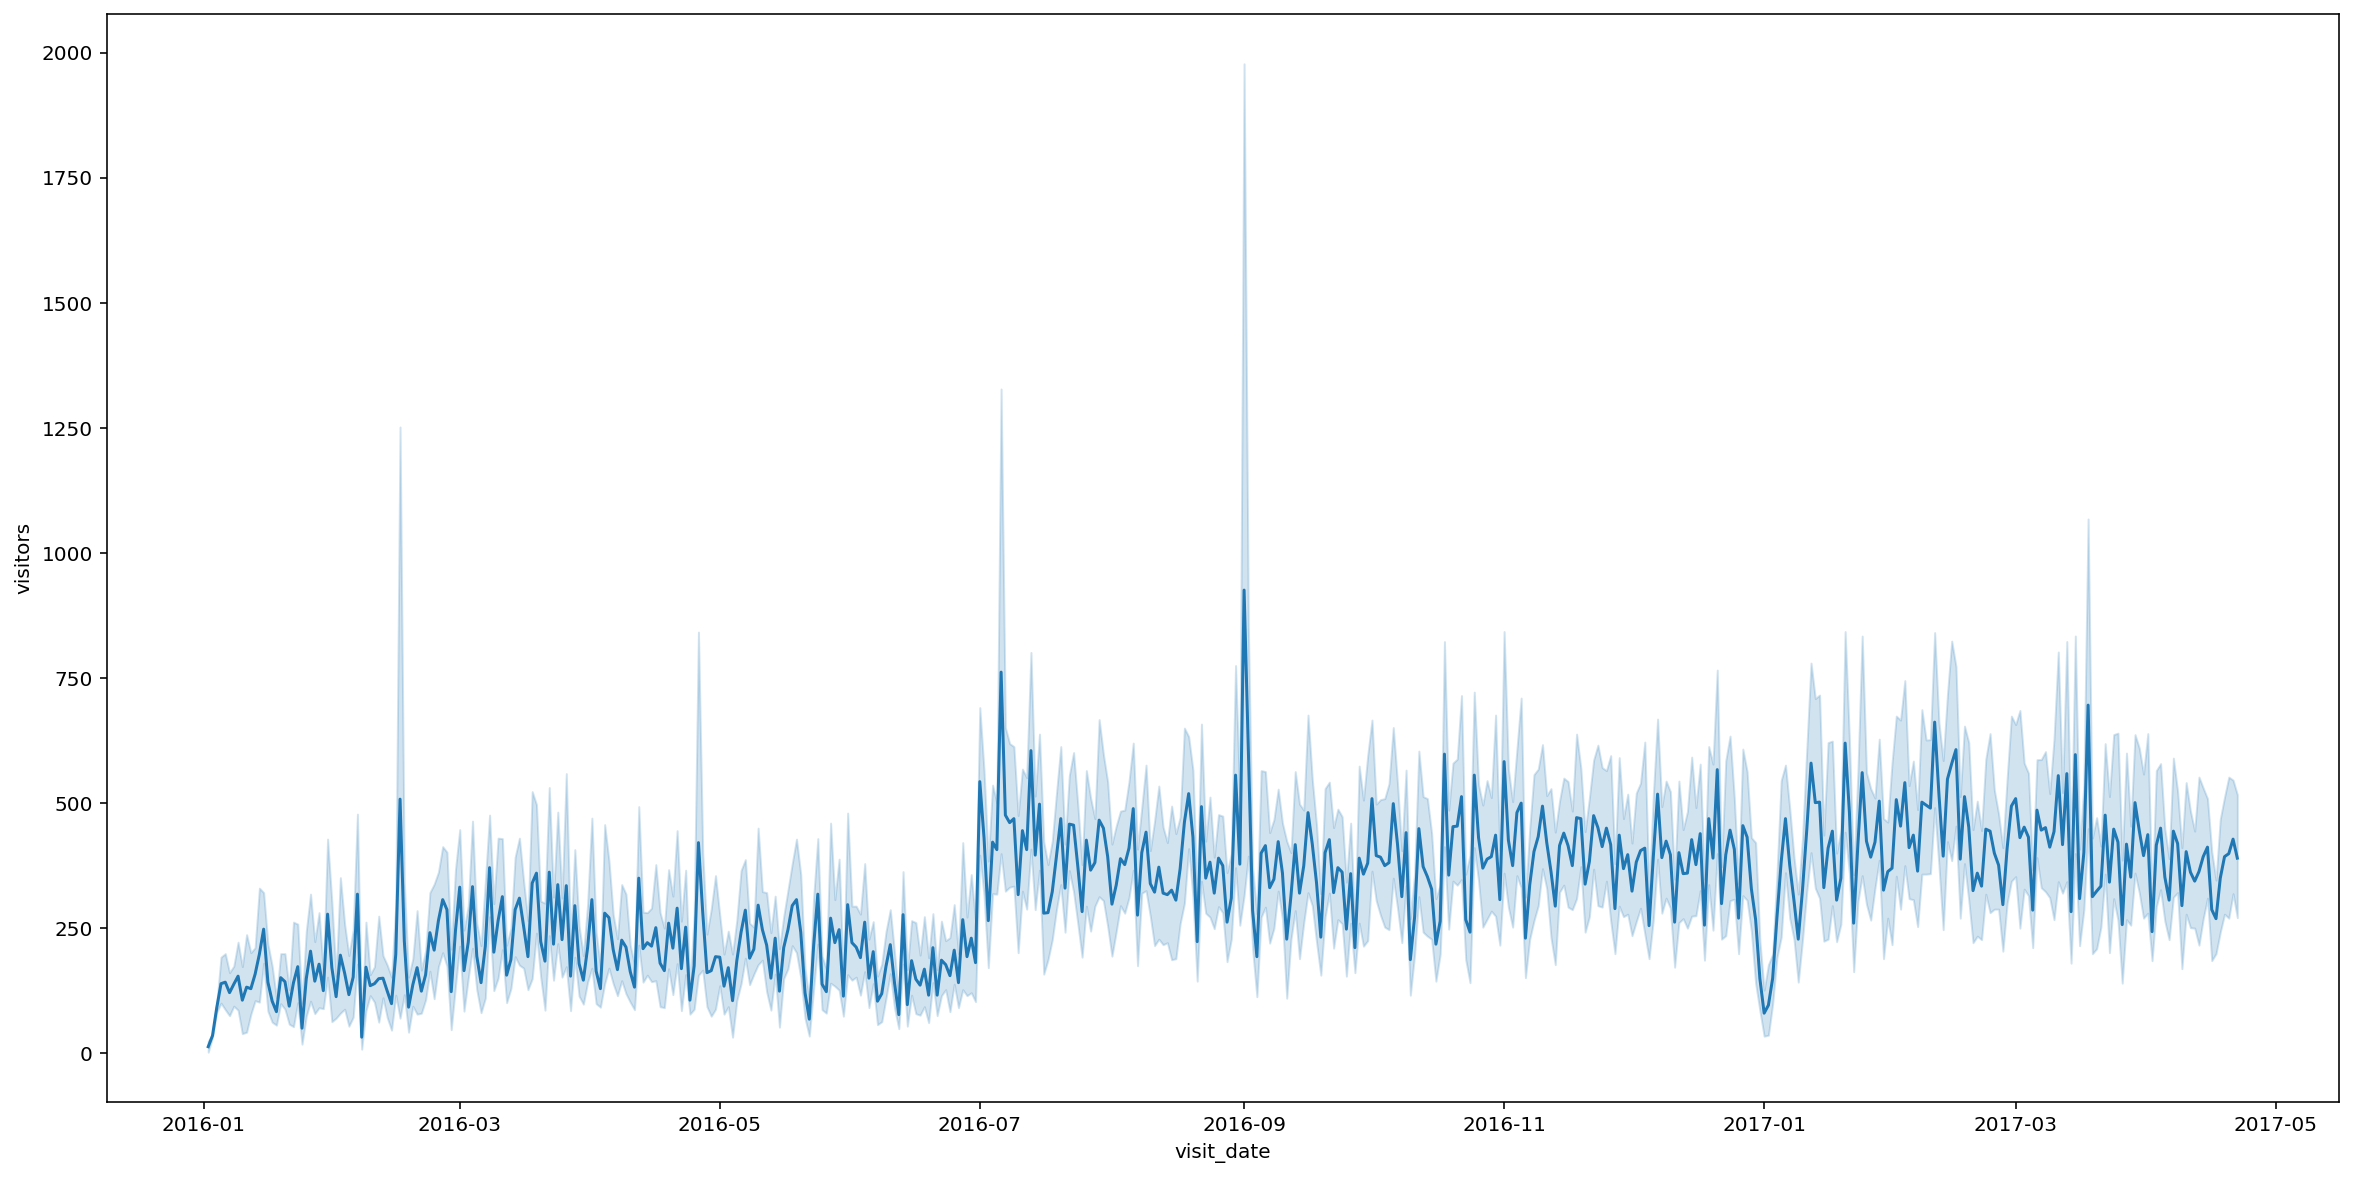

In [31]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1)], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 1주 기간 시각화

In [33]:
air_visit_df['visit_week'] = air_visit_df['visit_date'].map(lambda x : x.isocalendar()[1])

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1) & (air_visit_df['visit_week'] == 2)], x='visit_date', y='visitors', estimator=sum)
plt.show()

# 데이터 전처리

# 모델 학습

# 모델 평가